In [36]:
import pandas as pd
import json

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
# %matplotlib inline
%matplotlib notebook

In [2]:
def load_data():
    with open('calibration_data.txt') as f:
        list_of_dicts = []
        for line in f:
            d = json.loads(line)
            ax, ay, az = d['acc']
            d['ax'] = ax
            d['ay'] = ay
            d['az'] = az
            del d['acc']
            mx, my, mz = d['mag']
            d['mx'] = mx
            d['my'] = my
            d['mz'] = mz
            del d['mag']
            list_of_dicts.append(d)
    df = pd.DataFrame(list_of_dicts)
    return df

<IPython.core.display.Javascript object>


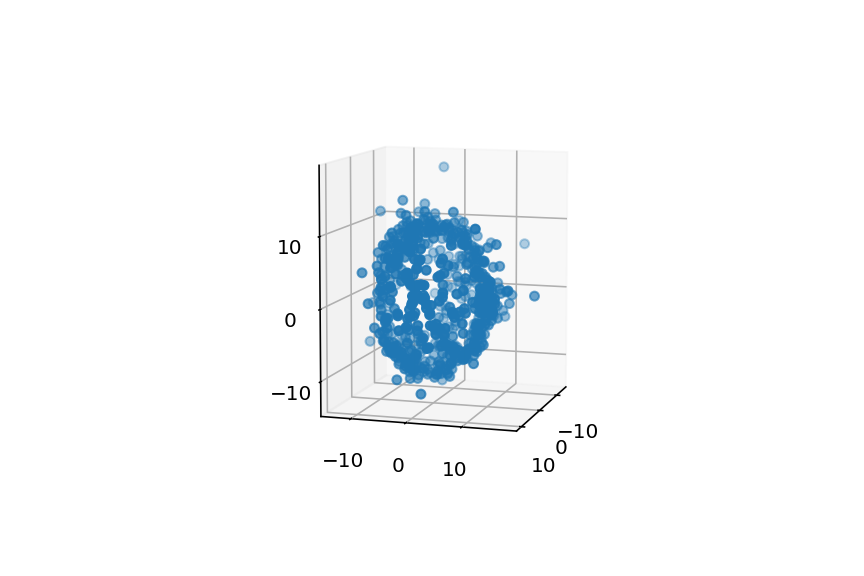

In [17]:
data = load_data()
fig = plt.figure()
ax = plt.axes(projection='3d', aspect='equal')
ax.scatter3D(data['ax'], data['ay'], data['az'])

<IPython.core.display.Javascript object>


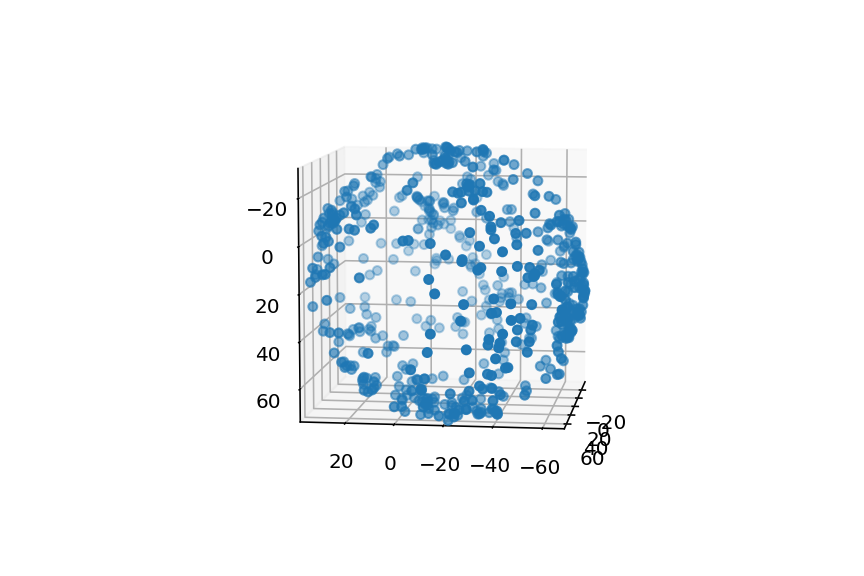

In [16]:
fig = plt.figure()
ax = plt.axes(projection='3d', aspect='equal')
# ax.axis('equal')
ax.scatter3D(data['mx'], data['my'], data['mz'])

In [18]:
data['r'] = ( data['mx']**2 + data['my']**2 + data['mz']**2 )**.5
# data['r']

In [22]:
data[['mx', 'my', 'mz']].to_csv('ellipsoid_fit_python/mag.csv', header=False, index=False, sep=' ')

In [29]:
from ellipsoid_fit_python.ellipsoid_fit import ellipsoid_fit, data_regularize

def find_fit(raw_mag):
    data2 = data_regularize(raw_mag, divs=8)

    center, radii, evecs, v = ellipsoid_fit(data2)
    params = center, radii, evecs, v
    return params
    
def apply_fit(params, raw_mag):
    center, radii, evecs, v = params
    centered = raw_mag - center.T
    
    a,b,c = radii
    r = (a*b*c)**(1./3.)#preserve volume?
    D = np.array([[r/a,0.,0.],[0.,r/b,0.],[0.,0.,r/c]])
    #http://www.cs.brandeis.edu/~cs155/Lecture_07_6.pdf
    #affine transformation from ellipsoid to sphere (translation excluded)
    TR = evecs.dot(D).dot(evecs.T)
    transformed = TR.dot(centered.T).T
    return transformed

In [30]:
mag_data = data[['mx', 'my', 'mz']].as_matrix()
fit_params = find_fit(mag_data)
corrected = apply_fit(fit_params, mag_data)

<IPython.core.display.Javascript object>


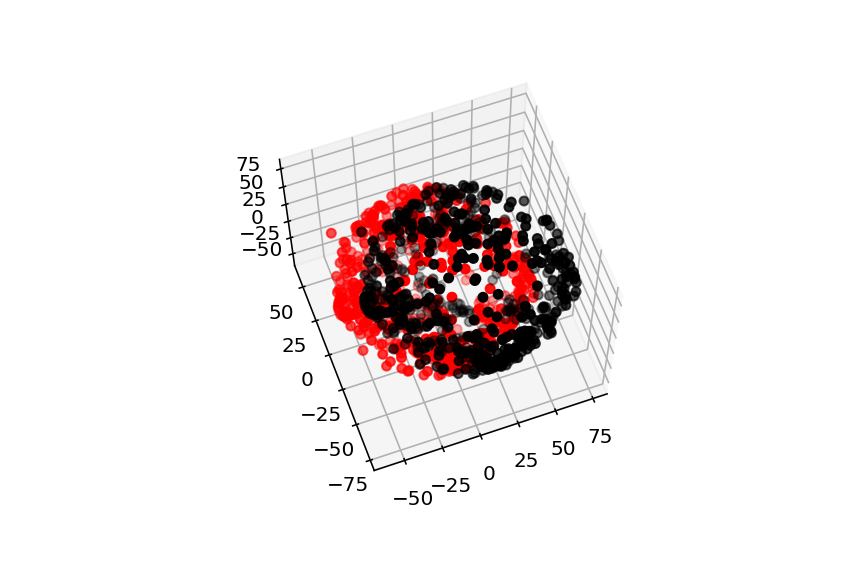

In [37]:
fig = plt.figure()
ax = plt.axes(projection='3d', aspect='equal')
# ax.axis('equal')
ax.scatter3D(mag_data[:,0], mag_data[:,1], mag_data[:,2], color='k')
ax.scatter3D(corrected[:,0], corrected[:,1], corrected[:,2], color='r')